## Best Score on Leader Board (22%):

#### model_a_ET
- `Elastic Net (l1_ratio=0.5, alpha=0.001, max_iter=1000)`
- `train_a1.csv, test_a1.csv from "AmesHousing-DataPreProcessingA" file`
    - One-Hot Encoded most of categorical features 
    - Except time related features & 'OverallCond'&'OverallQual'

## Import 

In [34]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [45]:
# import
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold #sklearn.cross_valication has KFold too, different
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Load Data (a1)

In [36]:
# load data (pre-processed)
train = pd.read_csv("train_a1.csv")
test = pd.read_csv("test_a1.csv")

## np array & drop "Id' col

In [37]:
X_train = train.iloc[:,1:-1].values # excule 'SalePrice'
y_train = train['SalePrice'].values

X_test = test.iloc[:,1:].values

print(X_train.shape, y_train.shape, X_test.shape)

(1458, 317) (1458,) (1459, 317)


In [38]:
train.isnull().sum().sum()

0

##  Log Transform of Sale Price

In [39]:
# Log Transform SalePrice 
y_train_log = np.log(train['SalePrice'].values)
print(y_train_log)

[12.24769432 12.10901093 12.31716669 ... 12.49312952 11.86446223
 11.90158345]


## Algorithm Evaluation 

In [43]:
def evalute_models(X,y,models,scoring_method='neg_mean_squared_error',num_folds=3,random_seed=7, scaler = None):
    '''
    models: list of (name, model)tuples) 
        E.g., models = [('ET',ElasticNet()), ('GBM',GradientBoostingRegressor())]                   
    scoring_method: scoring method
        E.g., scoring_method = 'neg_mean_squared_error' 
        scoring matrics: https://scikit-learn.org/stable/modules/model_evaluation.html
    scaler (in passin in): in form of instance
        E.g., scaler = StandardScaler()
    '''
    # pipeline models
    pipelines=[]
    if scaler == None:
        pipelines = models
    else:
        for name, model in models:
            pipelines.append((name,Pipeline([('Scaler',scaler),('Model',model)]))) 
    # evaluate     
    names = []
    results = []
    for name, model in pipelines:
        kfold=KFold(n_splits=num_folds, random_state=random_seed)
        cv_result = np.sqrt(-cross_val_score(model, X, y, scoring=scoring_method, cv=kfold,n_jobs=-1))
        results.append(cv_result)
        names.append(name)
        print("%s:%f(%f)"%(name, cv_result.mean(), cv_result.std()))
    # plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Algorithm Comparison')
    ax.boxplot(results)
    ax.set_xticklabels(names);
    return ax  

### Baseline

- no scaler

Lasso:0.168838(0.006124)
ET:0.161395(0.004254)
GBM:0.124614(0.006966)
XBG:0.125776(0.007434)


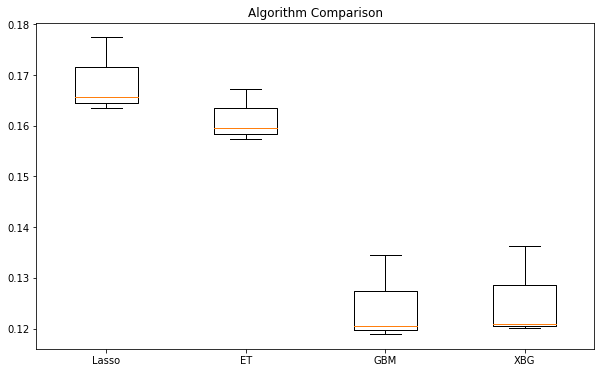

In [41]:
models = []
models.append(('Lasso',Lasso()))
models.append(('ET',ElasticNet()))
models.append(('GBM',GradientBoostingRegressor()))
models.append(('XBG',XGBRegressor()))

evalute_models(X_train, y_train_log, models)

- standscaler

Lasso:0.399587(0.010212)
ET:0.399587(0.010212)
GBM:0.124572(0.006965)
XBG:0.125828(0.007391)


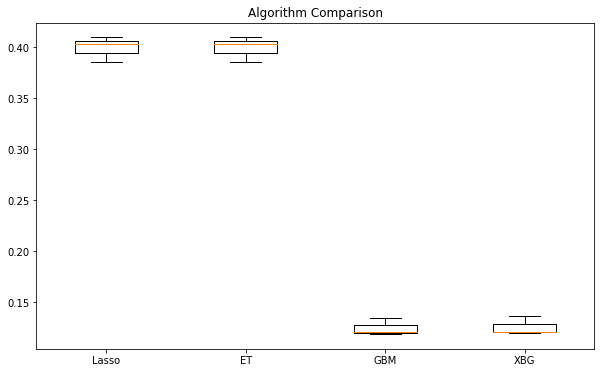

In [44]:
evalute_models(X_train, y_train_log, models, scaler=StandardScaler())

- Lasso, ET: Worse Score with StandardScaler
- GBM, XGB: No Obvious Improvement with StandardScaler

## Tune Algorithms

In [48]:
def tune_model(name,model,param_grid,X,y,scoring='neg_mean_squared_error',num_folds=3,rand_seed=7):
    kfold = KFold(n_splits=num_folds, random_state=rand_seed)
    # Grid Search CV
    grid = GridSearchCV(model, param_grid, scoring, n_jobs=-1, cv=kfold, return_train_score= True)
    grid_result = grid.fit(X, y)
    print(name)
    print('BestTestScore: %.6f %s'%(grid_result.best_score_, grid_result.best_params_))
    return None

### XGB

In [49]:
# name
name = 'XGB'
# model
model = XGBRegressor()
# param_grid (learning_rate, n_estimators)
param_grid = {}
param_grid['max_depth']=[2,3]
param_grid['learning_rate']=[0.05,0.1,0.15]
param_grid['n_estimators']=[200,300,400]
print(param_grid)

# tune
tune_model(name, model, param_grid, X_train,y_train_log)

{'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [2, 3], 'n_estimators': [200, 300, 400]}
XGB
BestTestScore: -0.014471 {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 400}


- Fine Tune 'learning_rate' & 'n_estimators'

In [50]:
# model
model = XGBRegressor(max_depth=2)
# param_grid (learning_rate, n_estimators)
param_grid = {}
param_grid['learning_rate']=[0.13,0.15,0.17]
param_grid['n_estimators']=[380,400,420]
print(param_grid)

# tune
tune_model(name, model, param_grid, X_train,y_train_log)

{'learning_rate': [0.13, 0.15, 0.17], 'n_estimators': [380, 400, 420]}
XGB
BestTestScore: -0.014454 {'learning_rate': 0.15, 'n_estimators': 380}


- subsample
- col_sample_bytree
- col_sample_bylevel

In [52]:
# model
model = XGBRegressor(max_depth=2, n_estimators=380)

# param_grid 
param_grid = {}
param_grid['learning_rate']=[0.13,0.14,0.15] #default 0.1
param_grid['subsample']=[0.8,0.9, 1] #default 1
param_grid['col_sample_bytree']=[0.8, 0.9, 1] #default 1
param_grid['col_sample_bylevel']=[0.8, 0.9, 1] #default 1
param_grid

# tune
tune_model(name, model, param_grid, X_train,y_train_log)

XGB
BestTestScore: -0.014277 {'learning_rate': 0.13, 'col_sample_bylevel': 0.8, 'subsample': 0.8, 'col_sample_bytree': 0.8}


### EN

In [55]:
# name
name = 'EN'
# model
model = ElasticNet()
# param_grid (learning_rate, n_estimators)
param_grid = {'alpha':[1,0.01,0.001],
             'l1_ratio':[0.5, 0.9],
             'max_iter':[1000,10000]}
# tune
tune_model(name, model, param_grid, X_train,y_train_log)

EN
BestTestScore: -0.013044 {'l1_ratio': 0.5, 'alpha': 0.001, 'max_iter': 1000}


In [62]:
# param_grid (learning_rate, n_estimators)
param_grid = {'alpha':[0.0011,0.001,0.0009],
             'l1_ratio':[0.48,0.5,0.52,0.55],
             'max_iter':[900,1000,2000]}
# tune
tune_model(name, model, param_grid, X_train,y_train_log)

EN
BestTestScore: -0.013039 {'l1_ratio': 0.55, 'alpha': 0.001, 'max_iter': 900}


## Submission

- model_a_ET(l1_ratio=0.5, alpha=0.001, max_iter=1000)

In [57]:
# train model_a_ET
model_a_ET = ElasticNet(l1_ratio=0.5, alpha=0.001, max_iter=1000)
model_a_ET.fit(X_train, y_train_log)
print('model_a_ET:', model_a_ET.score(X_train,y_train_log))

model_a_ET: 0.9378273971134141


In [58]:
prediction_a_ET = model_a_ET.predict(X_test)
prediction_a_ET

array([11.68807844, 11.8998396 , 12.08657074, ..., 12.0372155 ,
       11.66097933, 12.32287863])

In [59]:
saleprice_a_ET= np.exp(prediction_a_ET)

# Create submission df
submission_a_ET = pd.DataFrame({'Id':test['Id'], 'SalePrice':saleprice_a_ET})
submission_a_ET.head(3)

,Id,SalePrice
0,1461,119142.846706
1,1462,147243.004973
2,1463,177472.463586


In [60]:
# Save submission df to .csv file
submission_a_ET.to_csv("submission_a_ET.csv", index=False)

- model_a_ET2(l1_ratio=0.55, alpha=0.001, max_iter=900)

In [65]:
# train model_a_ET2
model_a_ET2 = ElasticNet(l1_ratio=0.55, alpha=0.001, max_iter=900)
model_a_ET2.fit(X_train, y_train_log)
print('model_a_ET2:', model_a_ET2.score(X_train,y_train_log))

model_a_ET2: 0.9370365295101359


In [66]:
prediction_a_ET2 = model_a_ET2.predict(X_test)
prediction_a_ET2

array([11.68937266, 11.89833563, 12.08595995, ..., 12.03912808,
       11.66259677, 12.3277782 ])

In [67]:
saleprice_a_ET2= np.exp(prediction_a_ET2)

# Create submission df
submission_a_ET2 = pd.DataFrame({'Id':test['Id'], 'SalePrice':saleprice_a_ET2})
submission_a_ET2.head(3)

,Id,SalePrice
0,1461,119297.142682
1,1462,147021.723287
2,1463,177364.098960


In [68]:
# Save submission df to .csv file
submission_a_ET2.to_csv("submission_a_ET2.csv", index=False)

# Other Trials (without score improvement)

## Use A2 Data (skewness corrected)

## Load Data (a2)

In [70]:
# load data (pre-processed)
train2 = pd.read_csv("train_a2.csv")
test2 = pd.read_csv("test_a2.csv")

## np array & drop "Id' col

In [71]:
X_train2 = train2.iloc[:,1:-1].values # excule 'SalePrice'

X_test2 = test2.iloc[:,1:].values

print(X_train2.shape, X_test2.shape)

(1458, 317) (1459, 317)


### Baseline

Lasso:0.299072(0.007856)
ET:0.296161(0.006203)
GBM:0.124519(0.007165)
XBG:0.125778(0.007433)


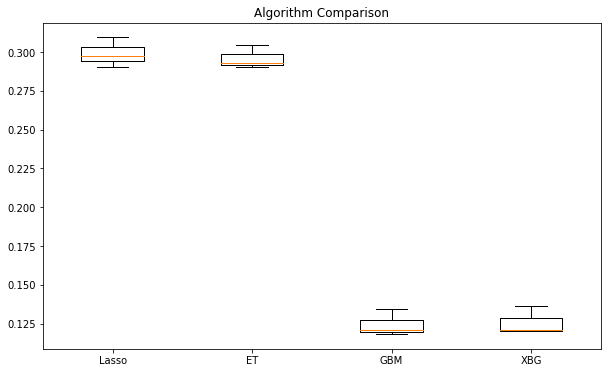

In [73]:
models = []
models.append(('Lasso',Lasso()))
models.append(('ET',ElasticNet()))
models.append(('GBM',GradientBoostingRegressor()))
models.append(('XBG',XGBRegressor()))

evalute_models(X_train2, y_train_log, models)

### EN

In [79]:
# name
name = 'EN'
# model
model = ElasticNet()
# param_grid (learning_rate, n_estimators)
param_grid = {'alpha':[1,0.01,0.001],
             'l1_ratio':[0.5, 0.9],
             'max_iter':[1000,10000]}
# tune
tune_model(name, model, param_grid, X_train2,y_train_log)

EN
BestTestScore: -0.013079 {'l1_ratio': 0.5, 'alpha': 0.001, 'max_iter': 1000}


In [82]:
# param_grid (learning_rate, n_estimators)
param_grid = {'alpha':[0.0009,0.001],
             'l1_ratio':[0.4,0.5,0.55],
             'max_iter':[1000000,1000]}
# tune
tune_model(name, model, param_grid, X_train2,y_train_log)

EN
BestTestScore: -0.013051 {'l1_ratio': 0.4, 'alpha': 0.0009, 'max_iter': 1000000}


## Use A3 Data (skewness corrected, Year-categorized)

## Load Data (a3)

In [74]:
# load data (pre-processed)
train3 = pd.read_csv("train_a3.csv")
test3 = pd.read_csv("test_a3.csv")

## np array & drop "Id' col

In [75]:
X_train3 = train3.iloc[:,1:-1].values # excule 'SalePrice'

X_test3 = test3.iloc[:,1:].values

print(X_train3.shape, X_test3.shape)

(1458, 617) (1459, 617)


### Baseline

Lasso:0.399587(0.010212)
ET:0.399587(0.010212)
GBM:0.134944(0.010139)
XBG:0.134486(0.011985)


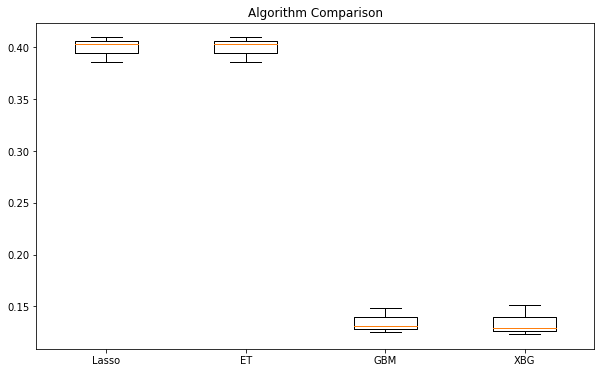

In [77]:
models = []
models.append(('Lasso',Lasso()))
models.append(('ET',ElasticNet()))
models.append(('GBM',GradientBoostingRegressor()))
models.append(('XBG',XGBRegressor()))

evalute_models(X_train3, y_train_log, models)

### EN

In [83]:
# name
name = 'EN'
# model
model = ElasticNet()
# param_grid (learning_rate, n_estimators)
param_grid = {'alpha':[1,0.01,0.001],
             'l1_ratio':[0.5, 0.9],
             'max_iter':[1000,10000]}
# tune
tune_model(name, model, param_grid, X_train3,y_train_log)

EN
BestTestScore: -0.013846 {'l1_ratio': 0.5, 'alpha': 0.001, 'max_iter': 1000}


### XGB

In [85]:
# name
name = 'XGB'
# model
model = XGBRegressor()
# param_grid (learning_rate, n_estimators)
param_grid = {}
param_grid['max_depth']=[2,3,4]
param_grid['learning_rate']=[0.05,0.1,0.15]
param_grid['n_estimators']=[100,300,1000]
print(param_grid)

# tune
tune_model(name, model, param_grid, X_train2,y_train_log)

{'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [2, 3, 4], 'n_estimators': [100, 300, 1000]}
XGB
BestTestScore: -0.014238 {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 1000}
